In [28]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [29]:
epochs = 100
lr = 1e-3
batch_size = 64

In [30]:
# 设置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
trans_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

In [32]:
trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942, 0.4851, 0.4504], std=[0.2467, 0.2429, 0.2616]),
])

In [33]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=trans_train)

test_data = datasets.CIFAR10('data', train=False, download=True, transform=trans_test)

Files already downloaded and verified
Files already downloaded and verified


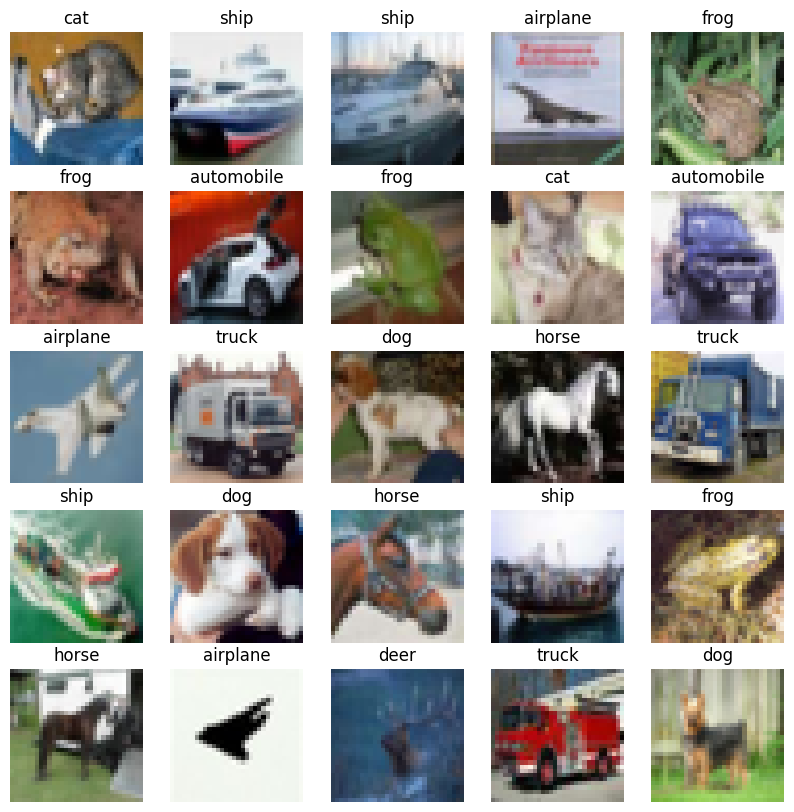

In [34]:
# CIFAR-10 classes
from matplotlib import pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get the first 25 images and labels from the test dataset
images = test_data.data[:25]
labels = test_data.targets[:25]

# Create a figure with 5 rows and 5 columns
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images and labels, and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'{class_names[labels[i]]}')

# Show the figure
plt.show()

In [35]:
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))

# 进行随机洗牌
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# 使用 SequentialSampler 以保持数据顺序
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoader 使用定义的 sampler，保持数据加载的顺序性
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [36]:
# def mean_std(loader):
#     data = next(iter(loader))[0]
#     mean = torch.mean(data, dim=[0, 2, 3])
#     std = torch.std(data, dim=[0, 2, 3])
#     return mean, std

# train_mean, train_std = mean_std(train_loader)
# test_mean, test_std = mean_std(test_loader)
# print("train_mean：{}".format(train_mean))
# print("train_std：{}".format(train_std))
# print("test_mean：{}".format(test_mean))
# print("test_std：{}".format(test_std))

In [37]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积层，输入通道为3（RGB图像），输出通道为32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # 第二层卷积层，输入通道为32，输出通道为64
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # 第三层卷积层，输入通道为64，输出通道为128
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        # 全连接层
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10有10个类别

    def forward(self, x):
        # 第一层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        # 第二层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        # 第三层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        # 展平
        x = x.view(-1, 128 * 4 * 4)
        # 全连接层+激活
        x = nn.functional.relu(self.fc1(x))
        # 输出层
        x = self.fc2(x)
        return x

In [38]:
# 实例化模型
model = Net().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [39]:
# 训练模型
def train_model(model, train_loader, valid_loader, epochs, device, criterion, patience=3):
    train_losses = []
    best_loss = float('inf')
    counter = 0 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {validation_accuracy}%')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping triggered.')
                break

    return train_losses



# def train_model(model, train_loader, valid_loader, epochs, device):
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             # 梯度清零
#             optimizer.zero_grad()

#             # 前向传播
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # 反向传播和优化
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

#         # 在验证集上评估模型性能
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for images, labels in valid_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         print(f'Validation Accuracy: {100 * correct / total}%')

In [40]:
# 测试模型
def test_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')
    return correct / total

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Get the predicted labels for the test dataset

import seaborn as sns

def test_draw_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

    # Convert the predicted labels and true labels to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(test_data.targets[:len(y_pred)])

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy and recall
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    return accuracy, recall

In [42]:
# lrs = [1e-1, 1e-2, 1e-3, 1e-4]

# import matplotlib.pyplot as plt

# train_losses = []
# test_accuracies = []
# test_recalls = []


# for lr in lrs:
#     model = Net().to(device)
#     loss_func = nn.CrossEntropyLoss()
#     optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#     print(f'Learning rate: {lr}')
#     losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
#     train_losses.append(losses)
#     print()
#     # 在训练完成后，调用测试函数
#     test_accuracy, test_recall = test_draw_model(model, test_loader, device)
#     test_accuracies.append(test_accuracy)
#     test_recalls.append(test_recall)

# for i, losses in enumerate(train_losses):
#     plt.plot(losses, label=f'LR: {lrs[i]}')

# plt.title('Training Loss for different lr')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# # Create a table to compare test accuracy for each learning rate
# import pandas as pd

# data = {'Learning Rate': lrs, 'Test Accuracy': test_accuracies}
# df = pd.DataFrame(data)
# print(df)

# data = {'Learning Rate': lrs, 'Test Recall': test_recalls}
# df = pd.DataFrame(data)
# print(df)



In [43]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchvision.models import vgg16

# train_losses = []
# lr=1e-3

# # Instantiate the VGG16 model
# model = vgg16(num_classes=10).to(device)

# # Define the loss function and optimizer
# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# # Train the model
# losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
# train_losses.append(losses)

# # Plot the training losses for each loss function
# for i, losses in enumerate(train_losses):
#     plt.plot(losses, label=f'VGG16')

# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for VGG16 Model')
# plt.legend()
# plt.show()

# print()
# # 在训练完成后，调用测试函数
# test_accuracy, test_recall = test_draw_model(model, test_loader, device)



In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion
            stride = 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.avg_pool2d(out, 4)  
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [45]:
# 实例化模型
model = ResNet(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)

# 检查是否有可用的GPU，如果有则使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [46]:
train_losses = []

# # 定义损失函数和优化器
# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# # Train the model
# losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
# train_losses.append(losses)


# for i, losses in enumerate(train_losses):
#     plt.plot(losses, label=f'resNet')

# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for resNet Model')
# plt.legend()
# plt.show()

# print()
# # 在训练完成后，调用测试函数
# test_accuracy, test_recall = test_draw_model(model, test_loader, device)

In [47]:
class ResNetDrop(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNetDrop, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion
            stride = 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.avg_pool2d(out, 4)  
        out = torch.flatten(out, 1)  # 展平特征图，保留batch维度
        out = F.dropout(out, p=0.5, training=self.training)  # 添加Dropout
        out = self.linear(out)
        return out

In [48]:
# # 实例化模型
# model = ResNetDrop(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)
# model = model.to(device)

# # 定义损失函数和优化器
# loss_func = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# # Train the model
# losses_drop = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
# train_losses.append(losses_drop)

# words = ['resNet', 'resNet using Dropout']

# for i, losses in enumerate(train_losses):
#     plt.plot(losses, label=words[i])

# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for resNet Model')
# plt.legend()
# plt.show()

# print()
# # 在训练完成后，调用测试函数
# test_accuracy, test_recall = test_draw_model(model, test_loader, device)

In [49]:
import torch.optim as optim

In [50]:
# 训练模型
def new_train_model(model, train_loader, valid_loader, epochs, device, criterion, optimizer, scheduler, patience=20, T_max = 100):
    train_losses = []
    best_loss = float('inf')
    counter = 0 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        valid_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():

            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                valid_loss += loss.item()

        validation_accuracy = 100 * correct / total

        # 更新学习率
        # scheduler.step(valid_loss)
        scheduler.step()
        print(f'Validation Accuracy: {validation_accuracy}%, Current Learn Rate: {scheduler.get_last_lr()[0]}')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping triggered.')
                break

    return train_losses

In [51]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# model = ResNet(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)

# model = model.to(device)

# # 定义损失函数和优化器
# loss_func = nn.CrossEntropyLoss()
# lr=1e-1
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

# losses_sched = new_train_model(model, train_loader, valid_loader, epochs, device, loss_func, optimizer, scheduler)

# new_train_losses = []
# new_train_losses.append(train_losses[0])
# new_train_losses.append(losses_sched)

# words = ['resNet', 'resNet using Scheduler']

# for i, losses in enumerate(new_train_losses):
#     plt.plot(losses, label=words[i])

# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for resNet Model Using Scheduler or not')
# plt.legend()
# plt.show()

# print()
# # 在训练完成后，调用测试函数
# test_accuracy, test_recall = test_draw_model(model, test_loader, device)

In [52]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# model = ResNet(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)

# model = model.to(device)

# # 修改猫和狗的权重
# weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0]).to(device)

# # 定义损失函数和优化器
# loss_func = nn.CrossEntropyLoss(weight=weights)
# lr=1e-1
# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)

# losses_sched = new_train_model(model, train_loader, valid_loader, epochs, device, loss_func, optimizer, scheduler)



In [53]:
# new_train_losses = []
# new_train_losses.append(losses_sched)

# words = ['resNet', 'resNet using Scheduler']

# for i, losses in enumerate(new_train_losses):
#     plt.plot(losses, label=words[i])

# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss for resNet Model Using Scheduler and Different Weights For Cat and Dog')
# plt.legend()
# plt.show()

# print()
# # 在训练完成后，调用测试函数
# test_accuracy, test_recall = test_draw_model(model, test_loader, device)

In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

model = ResNet(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)

model = model.to(device)

# 修改猫和狗的权重
weights = torch.tensor([1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0]).to(device)

# 定义损失函数和优化器
loss_func = nn.CrossEntropyLoss(weight=weights)
lr=1e-1
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=1e-4)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=8)
# 不使用简单的学习率下降，改为使用余弦退火
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

losses_sched = new_train_model(model, train_loader, valid_loader, epochs, device, loss_func, optimizer, scheduler)



Epoch 1, Loss: 2.127214489364624
Validation Accuracy: 28.45%, Current Learn Rate: 0.09997532801828658
Epoch 2, Loss: 1.7691135063171386
Validation Accuracy: 34.14%, Current Learn Rate: 0.09990133642141358
Epoch 3, Loss: 1.6025722290039062
Validation Accuracy: 41.17%, Current Learn Rate: 0.099778098230154
Epoch 4, Loss: 1.4661809106826782
Validation Accuracy: 44.05%, Current Learn Rate: 0.0996057350657239
Epoch 5, Loss: 1.3546416984558105
Validation Accuracy: 52.88%, Current Learn Rate: 0.09938441702975688
Epoch 6, Loss: 1.2579589403152467
Validation Accuracy: 54.31%, Current Learn Rate: 0.09911436253643444
Epoch 7, Loss: 1.1491117900848389
Validation Accuracy: 54.42%, Current Learn Rate: 0.09879583809693737
Epoch 8, Loss: 1.0567975220680237
Validation Accuracy: 64.95%, Current Learn Rate: 0.09842915805643156
Epoch 9, Loss: 0.969879825592041
Validation Accuracy: 64.01%, Current Learn Rate: 0.09801468428384716
Epoch 10, Loss: 0.9057173466682434
Validation Accuracy: 66.98%, Current Learn 

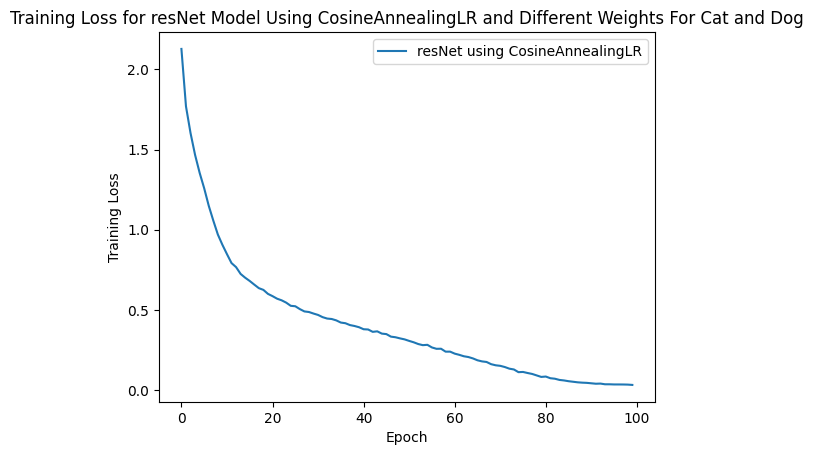

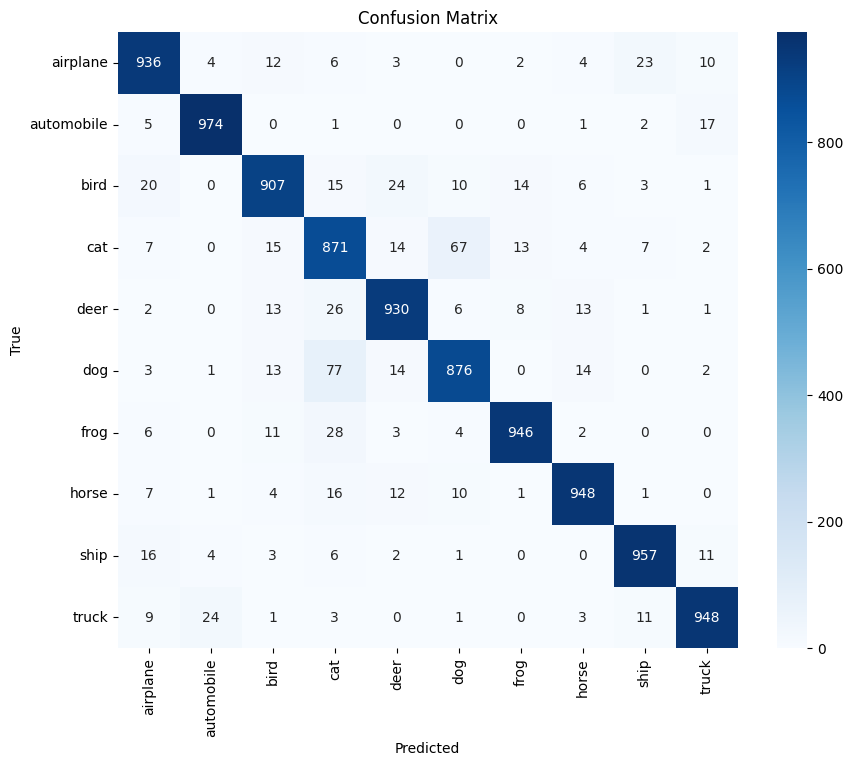

Accuracy: 0.9293
Recall: 0.9293000000000001


In [55]:
new_train_losses = []
new_train_losses.append(losses_sched)

words = ['resNet using CosineAnnealingLR']

for i, losses in enumerate(new_train_losses):
    plt.plot(losses, label=words[i])

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for resNet Model Using CosineAnnealingLR and Different Weights For Cat and Dog')
plt.legend()
plt.show()

print()
# 在训练完成后，调用测试函数
test_accuracy, test_recall = test_draw_model(model, test_loader, device)